1. k-평균을 사용할 때 적절한 클러스터 개수를 선택할 수 있는 두 가지 기법을 설명하세요.

이니셔가 최대한 많이 감소하는 지점의 k 선택, 실루엣 점수 계산하여 선택

2. 대규모 데이터셋으로 확장할 수 있는 군집 알고리즘 두 개를 말해보세요. 밀도가 높은 지역을 찾는 군집 알고리즘 두 개는 무엇인가요?

병합 군집 & BIRCH, DBSCAN & GMM

3. 가우시안 혼합이 무엇인가요? 어떤 작업에 사용할 수 있나요?

샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 상태. 이상치 탐지에 사용 가능

### 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## 올리베타 얼굴 데이터셋 군집하기

*전통적인 올리베티 얼굴 데이터셋은 64×64 픽셀 크기의 흑백 얼굴 이미지 400개를 담고 있습니다. 각 이미지는 4,096 크기의 1D 벡터로 펼쳐져 있습니다. 사람 40명의 사진을 10장씩 찍은 것입니다. 어떤 사람의 사진인지 예측하는 모델을 훈련하는 것이 일반적입니다. sklearn.datasets.fetch_olivetti_faces() 함수를 사용해 데이터셋을 불러오겠습니다.*

In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()
print(olivetti.DESCR)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/hyeminchon/scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal posi

In [3]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누겠습니다(이 데이터셋은 이미 0에서 1 사이로 스케일이 조정되어 있습니다). 이 데이터셋은 매우 작으니 계층적 샘플링을 사용해 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하는 것이 좋습니다.*

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [5]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


*속도를 높이기 위해 PCA로 데이터 차원을 줄이겠습니다.*

In [6]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

K-평균을 사용해 이미지를 군집해보겠습니다.

In [7]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


**5. 문제 : sklearn.metrics의 silhouette_score과 다음 코드로 보여지는 그래프를 보고 적절한 클러스터 개수를 확인하세요**

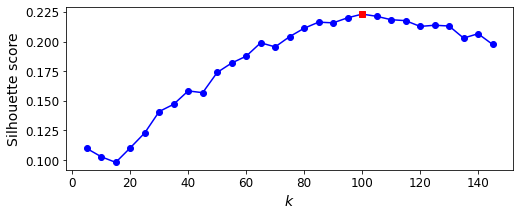

In [8]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

실루엣 score가 가장 큰 k=100을 적절한 클러스터 개수로 선택한다.

**6. 문제 : 이너셔 그래프 (inertias)를 그려보고, 최적의 클러스터 개수를 구할 수 있는지 확인하세요. (엘보우 지점이 있는지 확인해보세요)**

힌트: 코드의 각주를 풀고, 문제 5번의 시각화 코드를 조금만 수정해보세요

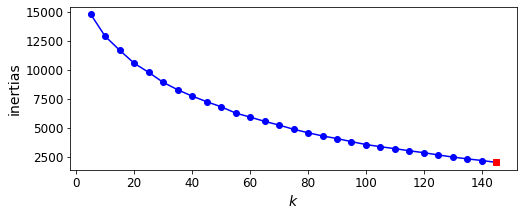

In [9]:
#inertias = [model.inertia_ for model in kmeans_per_k]
#best_inertia = inertias[best_index]

inertias = [model.inertia_ for model in kmeans_per_k]
best_index = np.argmin(inertias)
best_inertia = inertias[best_index]
best_k = k_range[best_index]
best_score = inertias[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("inertias", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()